# Performing a preliminary conjunction analysis
In this tutorial we will perform a preliminary analysis of conjunction risks to show how to read and propagate TLEs. 
We make use of an all.tle file, an updated version of which is available for download from https://www.space-track.org/ for authenticated users. Alternatively, similar data can be retrieved from https://celestrak.com/NORAD/elements/


In [1]:
# Core imports
import pykep
import scipy
import numpy as np
from scipy.stats import weibull_min

# Plotting and cosmetics
import matplotlib.pyplot as plt
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib notebook

In [2]:
# Here we import all the objects in the catalogue all.tle into pykep.planet objects
sats = pykep.util.read_tle(tle_file="all.tle", with_name=True)
# As an example we print the first imported object 
print(sats[0])

Planet Name: 1958-002B  
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 398600800000000
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Ephemerides type: SGP4 propagator
TLE epoch: 2020-May-23 18:16:51.524548
TLE 1: 1     5U 58002B   20144.76170746 +.00000174 +00000-0 +19302-3 0  9999
TLE 2: 2     5 034.2596 304.3715 1847756 241.1982 099.0858 10.84848451202572



## A snapshot of the imported population
We plot the position of all objects at some epoch.

In [3]:
# This is the epoch
epoch = pykep.epoch_from_string("2020-May-22 21:41:31.974735")

In [4]:
# Here we compute cartesian components of all the population calling the method
# ephemerides (an sgp4 propagator will be used under the hood)
xs = []
ys = []
zs = []
for s in sats:
    try:
        r, v = s.eph(epoch)
        xs.append(r[0]/pykep.EARTH_RADIUS)
        ys.append(r[1]/pykep.EARTH_RADIUS)
        zs.append(r[2]/pykep.EARTH_RADIUS)
        
    except:
        continue


<IPython.core.display.Javascript object>


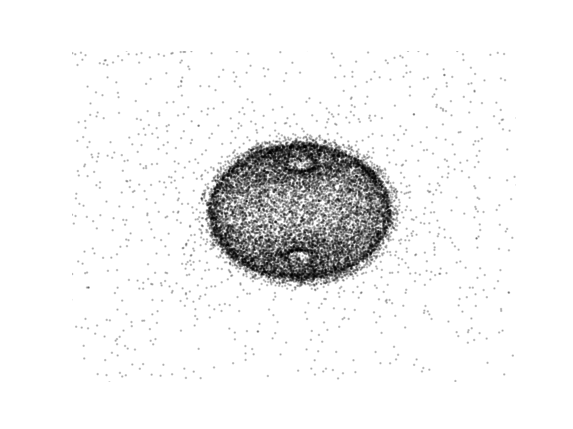

In [5]:
# Here we make the plot and define the viewpoint
fig = plt.figure()
minmax = (-1.5, 1.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs, alpha=0.2, s=1, c='k')
ax.axis("off")

# Set each axis limits
ax.set_xlim(minmax)
ax.set_ylim(minmax) 
ax.set_zlim(minmax) 

# Set the view
ax.view_init(elev=45., azim=90)

# Save the figure
#plt.savefig("leo", dpi=300)

## Building the distribution of closest approaches
Here we make a monte carlo simulation where we compute at a random epoch the closest distance of a chosen satellite, in our case Sentinel 3B (https://earth.esa.int/web/guest/missions/esa-eo-missions/sentinel-3), from all objects in sats.

In [6]:
# We define the satellite Sentinel 3B from its tle.
sentinel3b_l1="1 43437U 18039A   20145.62789730 +.00000000 +00000-0 +18124-4 0  9996"
sentinel3b_l2="2 43437 098.6292 212.6693 0000789 104.4098 255.7170 14.26736461108341"
sentinel3b = pykep.planet.tle(sentinel3b_l1, sentinel3b_l2)

In [7]:
# We make the Monte-Carlo simulation
# Number of runs, should be at least 100000 (hours to compute on a single CPU)
N = 10
# This is the lower bound for the epoch
t0 = 58991.90384230018
# This is the number of years to sample
years = 3
# This will contain the results
mins = []
# We loop
for i in progressbar.progressbar(range(N)):
    epoch = pykep.epoch(t0 + np.random.rand() * years * 365.25, "mjd")
    pos_sentinel3b, _ = np.array(sentinel3b.eph(epoch)) / pykep.EARTH_RADIUS
    
    # All the population
    xs = [0]*len(sats)
    ys = [0]*len(sats)
    zs = [0]*len(sats)
    for i,s in enumerate(sats):
        try:
            r, v = s.eph(epoch)
            xs[i] = r[0]/pykep.EARTH_RADIUS
            ys[i] = r[1]/pykep.EARTH_RADIUS
            zs[i] = r[2]/pykep.EARTH_RADIUS

        except:
            xs[i] = 0
            ys[i] = 0
            zs[i] = 0
            continue
    pos = np.array((xs,ys,zs)).T
    D = scipy.spatial.distance.cdist([pos_sentinel3b],pos)
    sat_id = np.argmin(D[0])
    D[0,sat_id] = 3
    mins.append(min(D[0]))


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [8]:
# The simulation can be long if we want many samples to be able to see well the left part of the curve
# It maybe then be worth saving the result 

import pickle as pk
#with open("monte_carlo_results.pk", "wb") as file:
#    pk.dump(mins, file)

# Here we load the results from a simulation having N = 100000
with open("monte_carlo_results.pk", "rb") as file:
    mins = pk.load(file)

<IPython.core.display.Javascript object>


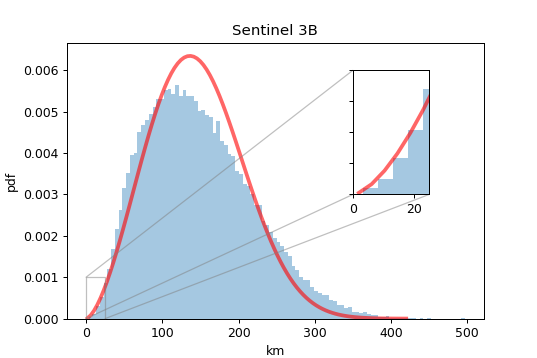

In [9]:
# We plot it together with a fitteb weibull
fig, ax = plt.subplots(figsize=[6, 4])
c, loc, scale = weibull_min.fit(np.array(mins))
# Try set c to a different value as to avoid to overrepresent the left tail
c = 2.6
# We will be using km
scale =  scale * pykep.EARTH_RADIUS / 1000
# This is the weibull fit
x = np.linspace(weibull_min.ppf(0.00001, c, 0, scale),  weibull_min.ppf(0.99999, c, 0, scale), 100)
ax.plot(x, weibull_min.pdf(x, c, 0, scale),'r-', lw=3, alpha=0.6, label='weibull_min pdf')
# This are the data
sns.distplot(np.array(mins) * pykep.EARTH_RADIUS / 1000, hist=True, kde=False, norm_hist=True, bins=100)
# And the same for the zoom in
axins = ax.inset_axes([350, 0.003, 100, 0.003], transform=ax.transData)
axins.set_yticklabels('')
axins.plot(x, weibull_min.pdf(x, c, 0, scale),'r-', lw=3, alpha=0.6, label='weibull_min pdf')
sns.distplot(np.array(mins) * pykep.EARTH_RADIUS / 1000, hist=True, kde=False, norm_hist=True, bins=100, ax = axins)
axins.set_xlim(0, 25)
axins.set_ylim(0, 0.001)
a, b=ax.indicate_inset_zoom(axins)
b[1].set_visible(True)
b[3].set_visible(False)
b[0].set_visible(True)
# Title and axis name
plt.title("Sentinel 3B")
plt.xlabel("km")
plt.ylabel("pdf")
plt.savefig("weibull", dpi=300)


In [10]:
# Here we compute, using the weibull distribution parameter fit, the expected TTC (time to collision)
# using the method from Chobotov
# Satellite cross section
rc = 0.002
# Orbital velocity
vr = 7.8
beta = scale
tau  = 2.6
chob = (beta/rc)**tau*np.pi/2*rc/vr
ttc = chob * pykep.SEC2DAY / 365.25
print("TTC in years: ", ttc)

TTC in years:  76.33899004256261


We can conclude that a Weibull distribution is not a good fit to represent the distribution of close encounters in LEO as it tends to overrepresent the events with a close distance that could result in an impact.